In [1]:
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.integrate import quad
from sympy import init_printing, Symbol, Matrix, simplify, lambdify, Array, diff, symbols, integrate, exp, sqrt
from numpy.polynomial.legendre import leggauss  #Gauss-Legendre Quadrature for 1D
from jupyterthemes import jtplot
jtplot.style()
init_printing()
plt.rc('text', usetex=True)
plt.rcParams['font.weight'] = 700
plt.rcParams['xtick.top']='True'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.right']='True'
plt.rcParams['ytick.direction']='in'
plt.rcParams['ytick.labelsize']=22
plt.rcParams['xtick.labelsize']=22
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.minor.size']=3
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.minor.size']=3
plt.rcParams['lines.markersize']=np.sqrt(36)
plt.rc('text',usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath,amsfonts,amssymb,bm}"]

In [2]:
# Computing the exact solution
x, r, xi, Ao, l, rhO, g, E, m, L = symbols("x, r, xi, Ao, l, rhO, g, E, m, L", real=True)
area = lambda x: Ao*exp(-x/l)
bf = lambda x: -rhO * area(x) * g
innerIntegral = lambda r: simplify(integrate(bf(xi), (xi, L, r)))
usol = simplify(-integrate(1./E/area(r)*innerIntegral(r), (r,0,x)) -m*g/E*integrate(1/area(r), (r,0,x)))

In [3]:
class geometry():
    def __init__(self, ne, deg):
        self.L = 324.
        self.g = 9.81
        self.E = 5.e8
        self.m = 2.e4
        self.l = 90.
        self.Ao = 120.**2
        self.rho = 1500.
        self.nNNodes=int(ne*deg+1)   #Isoparametric deg-th order lagrange elements
        self.ndim=1
        self.nLNodes=ne+1       #Linear elements
        self.nQNodes=2*ne+1

In [4]:
geom=geometry(2, 2)
usol = usol.subs([(Ao, geom.Ao), (rhO, geom.rho), (L, geom.L), (g, geom.g),
                  (m, geom.m), (E, geom.E), (l, geom.l)])
usol

In [5]:
sqrt(integrate(usol.diff(x)**2, (x, 0, geom.L)))

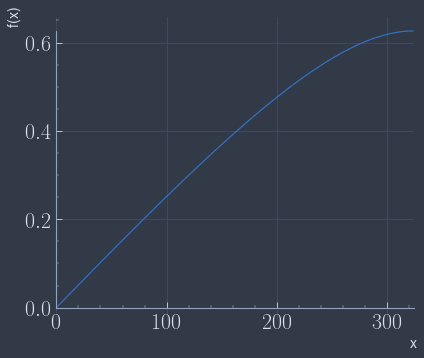

In [6]:
from sympy import plot
plot(-usol, (x, 0, geom.L))

In [7]:
uplot = lambdify(x, usol, "numpy")

In [8]:
class GPXi():
    def __init__(self, ordr):
        self.xi=leggauss(ordr)[0]
        self.wght=leggauss(ordr)[1]

In [9]:
class basis(): # defined on the canonical (master) element (1D : [-1,1] ) 
    def __init__(self,deg,basis_type):
        deg = int(deg)
        if basis_type == 'L':          # 1D Lagrange basis of degree `deg`
            z=Symbol('z')
            Xi=np.linspace(-1,1,deg+1)
            def lag_basis(k):
                n = 1.
                for i in range(len(Xi)):
                    if k != i:
                        n *= (z-Xi[i])/(Xi[k]-Xi[i])
                return n
            N = Array([simplify(lag_basis(m)) for m in range(deg+1)])            
            dfN = diff(N,z)+1.e-25*N
            self.Ns=lambdify(z, N, "numpy")
            self.dN=lambdify(z, dfN, "numpy")
            self.enrich = 1  #enriched dofs (not needed for lagrange elements)

$$ N_1 = \frac{\xi(\xi - 1)}{2}\\
N_2 = {1-\xi^2}\\
N_3 = \frac{\xi(\xi + 1)}{2}\\
x = \sum_{k=1}^3 N_k(\xi) x_k \\
Je = \frac{dx}{d\xi} = \sum_{k=1}^3 \frac{d N_k}{d\xi}(\xi)x_k 
$$

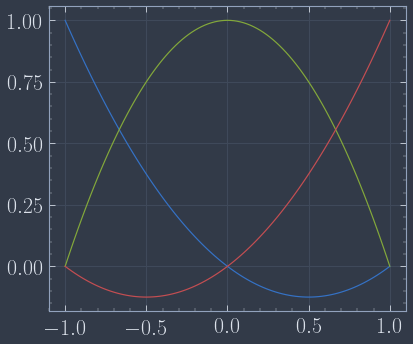

In [10]:
xpl_shp = np.linspace(-1,1,101)
nBasisPlot = basis(2, "L")
N = nBasisPlot.Ns(xpl_shp)
plt.figure()
plt.plot(xpl_shp, N[0])
plt.plot(xpl_shp, N[1])
plt.plot(xpl_shp, N[2])
# plt.plot(xpl_shp, N[3])

In [19]:
xi = leggauss(3)[0]
(162+0)/2.+xi*(162)/2

array([ 18.25766979,  81.        , 143.74233021])

In [11]:
def loc_mat(nodes, ElFlag, Ndnode):   #Computes the element quantities when supplied with gloabl nodes
    xi=GP.xi;W=GP.wght
    if etypes=='L':
        x = np.array(nB.Ns(xi)).T @ nodes
        print("Gauss Points: ",x)
        Je = np.array(nB.dN(xi)).T @ nodes
        print("Element: Jacobian = ", Je)
        a1 = np.array(B.dN(xi)).reshape(-1,1,W.size)  
        a2 = a1.reshape(1,len(a1),-1).copy()
        a1 *= geom.E/Je*A(x)*W       # multiply by weights, jacobian, A, in bitwise fashion 
        mat = np.tensordot(a1, a2, axes=([1,2],[0,2])) #+ np.tensordot(b1,b2,axes=([1,2],[0,2]))     #could potentially use einsum to clean it up (but works for now!)
        elemF = (np.array(B.Ns(xi))*W*Je*body_force(x)).sum(axis=1).flatten()
        return mat, elemF

def fsample(x, dof, nodes, sample_type): #giving out the displacement, strain and stress at x: GP and dof value of disp. at gauss point
    if sample_type=='spline':
        if int(El[1]) >5:
            k0=5
        else:
            k0 = int(El[1])
        dspl=splrep(nodes,dof,k=k0)
        return (x,splev(x,dspl))
    elif sample_type=='vandermonde':
        Xinew = np.linspace(-1, 1-1.e-13, 20)
        N = np.array(B.Ns(Xinew)).reshape(int(El[-1])+1, Xinew.size,-1)
        N = np.einsum('jik',N)
        Nx = np.array(nB.Ns(Xinew)).reshape(int(MapX[-1])+1,Xinew.size,-1)
        Nx = np.einsum('jik', Nx)
        dofarang = np.vstack((np.arange(k,k+dof.size-1,int(El[-1])) for k in range(int(El[-1])+1))) #arange dofs for multiplication with n
        dofarang=dofarang.reshape(int(El[-1])+1,1,-1)
        xarang = np.vstack((np.arange(k,k+nodes.size-1,int(MapX[-1])) for k in range(int(MapX[-1])+1)))
        xarang = xarang.reshape(int(MapX[-1])+1, 1, -1)
        dofs=dof[dofarang]
        nodesx=nodes[xarang]
        soln = np.einsum('ikj,kmj->imj',N,dofs)
        xpl = np.einsum('ikj,kmj->imj',Nx,nodesx)
        return (xpl.T.ravel(),soln.T.ravel()) # return the solution evaluated at the given points

In [12]:
def A(x):
    return geom.Ao*np.exp(-x/geom.l)

def body_force(x):
    return -geom.rho*A(x)*geom.g

In [13]:
El = "L1"
MapX = "L1"
Nel = 2 #number of elements
Np = 3
etypes = El[0]

In [14]:
if El[0]=='L':                   #1D Mapping function for the physical coordinates
    nB=basis(int(MapX[-1]), MapX[0])
    geom=geometry(Nel, int(MapX[-1])) 
    probsize=geometry(Nel, int(El[-1]))
    B=basis(int(El[-1]), El[0])     #Basis for FE fields (isoparametric) 
    GP=GPXi(Np) 
    nodes = np.linspace(0.,geom.L,geom.nNNodes)
    elems = np.vstack((np.arange(k,k+nodes.size-1, int(MapX[1])) for k in range(int(MapX[1])+1))).T
    globK = 0*np.eye(probsize.nNNodes)   # This changes because now we no longer have iso-p map
    globF = np.zeros(probsize.nNNodes)    
    prescribed_dof=np.array([[0,0]])

dof=np.inf*np.ones(globK.shape[0])
prescribed_forc = np.array([[-1, -geom.m*geom.g]])
dof[prescribed_dof[:,0]] = prescribed_dof[:,1]

c:\users\bshri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [15]:
elems

array([[0, 1],
       [1, 2]])

In [16]:
for k in range(elems[:,0].size): #Assembly of Global System
    elflag = 'nn'
    ndnode = 1
    elnodes=elems[k]
    if etypes=='L':
        elemord=int(El[-1])+1     # basically selecting the corresponding dof
        globdof = np.array([k*(elemord-1)+i for i in range(elemord)], int)
#         print(globdof)
    if etypes != '2D':                                                         # 1D lagrange or legendre polynomials 
        nodexy=nodes[elnodes]
    else:
        nodexy=nodexy[:,elnodes]
    kel, fel = loc_mat(nodexy,elflag,ndnode)
    globK[np.ix_(globdof,globdof)] += kel                                      #this process would change in vectorization 
    globF[globdof] += fel

globF[int(prescribed_forc[:,0])] += prescribed_forc[:,1]    
fdof=dof==np.inf                                                               # free dofs
nfdof=np.invert(fdof)   
print("Kglobal = \n",globK)
print("fGlobal = \n",globF)
if etypes=='L':  
    AA=globK[np.ix_(fdof,fdof)]
    bb=globF[fdof]-globK[np.ix_(fdof,nfdof)] @ dof[nfdof]                                                                           
    dofme=nla.solve(AA, bb)
dof[fdof]=dofme.copy()

Gauss Points:  [ 18.25766979  81.         143.74233021]
Element: Jacobian =  [81. 81. 81.]
Gauss Points:  [180.25766979 243.         305.74233021]
Element: Jacobian =  [81. 81. 81.]
Kglobal = 
 [[ 2.06095915e+10 -2.06095915e+10  0.00000000e+00]
 [-2.06095915e+10  2.40163341e+10 -3.40674256e+09]
 [ 0.00000000e+00 -3.40674256e+09  3.40674256e+09]]
fGlobal = 
 [-1.02262169e+10 -7.38220848e+09 -9.41048743e+08]


In [ ]:
xplot=np.linspace(0.,geom.L,10*geom.nNNodes-1)  #sampling points for the exact solution
fittype='vandermonde'
plot_it  = True

In [ ]:
if plot_it:
    if etypes=='L':
        if fittype == 'spline':
            xplot, uapp = fsample(xplot, dof[0:len(dof):int(El[1])], nodes[0:len(nodes):1], fittype)
        elif fittype == 'vandermonde':
            xplot, uapp = fsample(xplot, dof, nodes, fittype)

In [ ]:
uexact = list(map(uplot, xplot))
uexact = -1*np.array(uexact)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(xplot, uexact, "b-", lw=2, label=r"$\widetilde{{u}}(x)$")
plt.plot(xplot, -uapp,'--r', lw=2 , label=r'$u^h_{0:1d}(x)$'.format(int(El[-1])), markevery=4)
plt.legend(loc=0, fontsize=22, fancybox=False, edgecolor="white", shadow=True)
plt.ylabel(r"$u^h_{0:1d}(x)/\widetilde{{u}}(x)$".format(int(El[-1])), fontsize=24)
plt.xlabel(r"$x$", fontsize=24)
plt.grid(which="major", color="k")
plt.savefig("Displacement_deg_{}_nel_{}.eps".format(int(El[-1]), Nel))